Dans cette partie on étudie 6 méthodes de clustering avec nos données : K-Means, Hiérarchique, BDSCAN, Mean Shift, Affinity Propagation et Spéctral. On verra que pas toutes ces méthodes de clustering sont compatibles avec notre jeu de données.  
  
On importe d'abord ce qu'il faut.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import get_cmap
from time import time

from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, AffinityPropagation, \
    SpectralClustering, MeanShift
from sklearn import metrics

import dill as pickle

index_sampled = pickle.load(open("simpleIndex", "rb"))
tsne = pickle.load(open("tSNE", "rb"))
df_tsne_2d = tsne.embedding_
df_encoded = pickle.load(open("autoencoder", "rb"))
drawData = pickle.load(open("drawData", "rb"))

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1085: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
complete_preprocessed = pd.read_pickle("preprocessed")
complete_preprocessed.head()
complete = pd.read_pickle("complete")

On se rapelle que pour la visu des clusterings il faut prendre soit le t-SNE, soit l'auto-encodeur, mais pas l'ACP, pour la raison suivante.

In [3]:
ipca = IncrementalPCA(n_components=10, batch_size=30)
df_pca = ipca.fit_transform(complete_preprocessed)
ipca.explained_variance_ratio_.cumsum()


array([0.15970458, 0.24622809, 0.32275451, 0.39738982, 0.46496188,
       0.51779215, 0.55724697, 0.59144712, 0.62383674, 0.65274646])

ça veut dire que les variances éxpliquées par des composantes principales sont réparties de façon relativement équilibrée et qu'on aura mal à représenter les données par seulement quelques composantes. On ne peut donc pas utiliser cette méthode de réduction de dimensions courante.

In [9]:
df_pre_sampled = complete_preprocessed.iloc[index_sampled]

On commence par K-Means. On met par hasard le nombre de clusters à 5. On voit que le résultat présenté par l'auto-encodeur est assez bon : il a retrouvé les salariés > 50K ; les femmes dans le sous-groupe salaire <= 50K ainsi que d'autres points qui se regroupent de façon naturelle.  

In [8]:
kmeans = KMeans(n_clusters = 5)
kmeans.fit_transform(complete_preprocessed)

array([[2.20562964, 1.98743022, 2.49607691, 2.10193886, 1.44371001],
       [1.68000443, 1.08443439, 1.84713227, 1.68117915, 1.78071208],
       [2.46730663, 2.11555636, 1.5843568 , 2.48470643, 2.56544873],
       ...,
       [1.43726428, 2.0462457 , 2.44677795, 2.13104565, 2.27213062],
       [2.00581413, 1.79692693, 2.30992348, 1.87099925, 1.0614474 ],
       [2.43888493, 2.53016902, 1.89101731, 2.67693538, 2.7990371 ]])

5


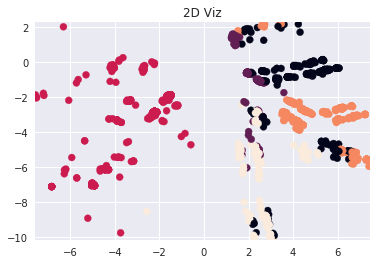

In [10]:
drawData(df_encoded, pd.Series(kmeans.labels_[index_sampled]))

Ensuite on essaie le clustering hiérarchique (agglomératif). On peut faire plusieurs choses avec cette méthode. En premier lieu, on fait un double-clustering par rapport aux observatiosn et par rapport aux variables.   
  
Puis on compare la performance des trois linkages : "ward", "average" et "complete", en mettant par hasard le nombre de clusters à 6. On voit que "ward" et "complete" fonctionne aussez bien.

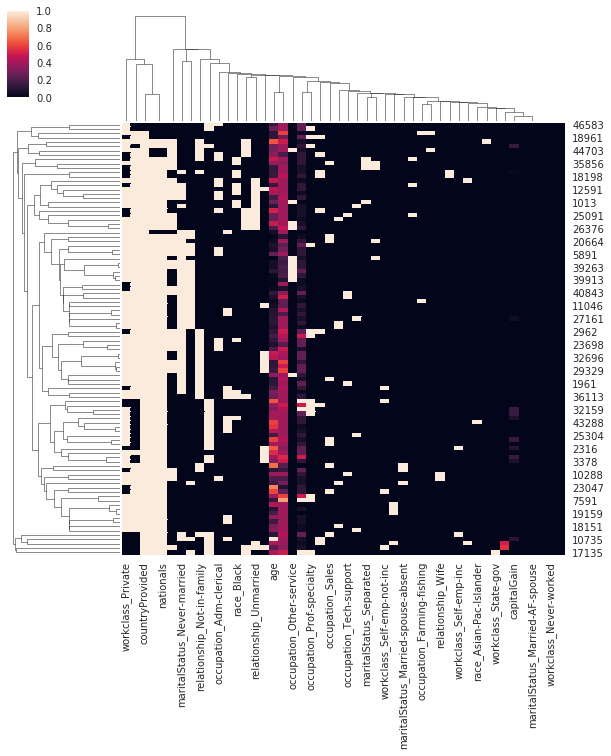

In [14]:
plt.figure()
sns.clustermap(complete_preprocessed.sample(100), row_cluster = True)
plt.show()

ward : 0.15s
6
average : 0.15s
6
complete : 0.15s
6


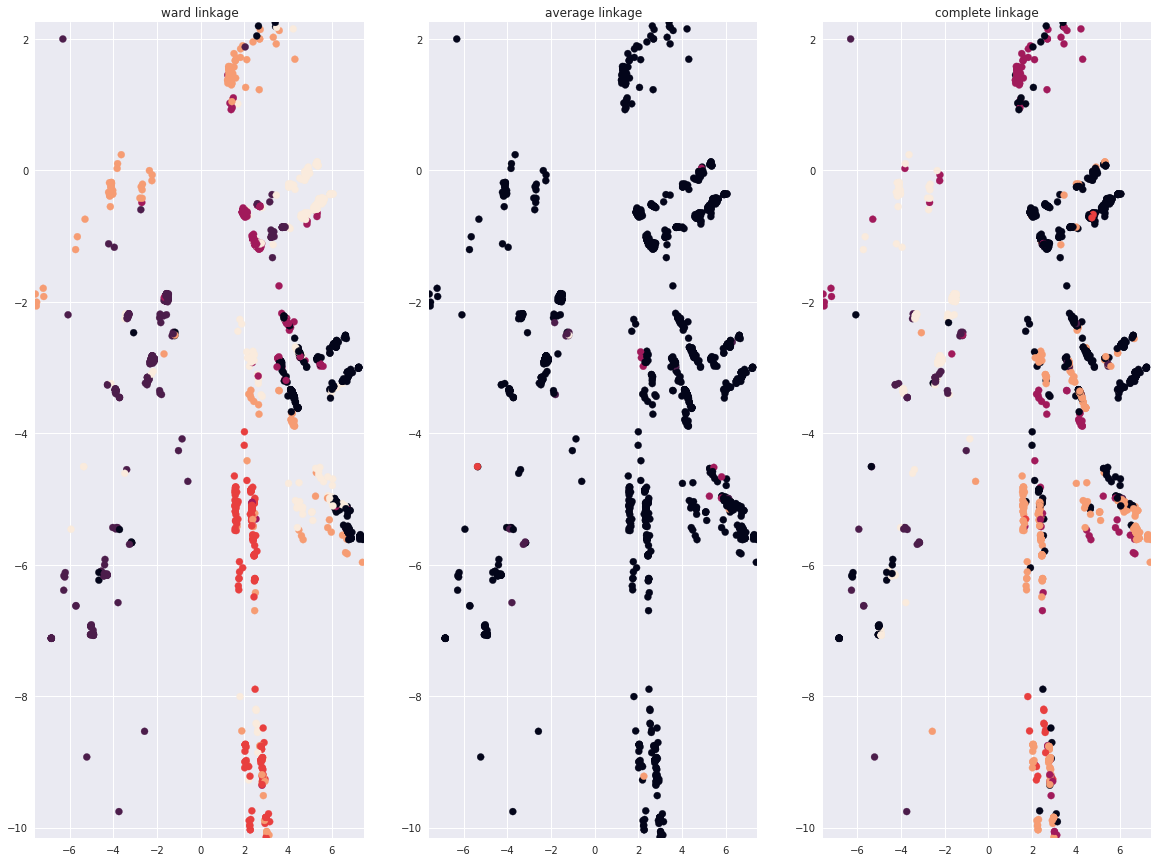

In [17]:
plt.figure(figsize=(20, 15))

for i, linkage in enumerate(['ward', 'average', 'complete']):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=6)
    t0 = time()
    clustering.fit(df_pre_sampled)
    print("%s : %.2fs" % (linkage, time() - t0))

    plt.subplot(1, 3, i+1)
    drawData(df_encoded, pd.Series(clustering.labels_), 
             titre = "%s linkage" % linkage)


plt.show()


On s'intéresse aussi à DBSCAN. Cette méthode est basée sur la densité des nuages de points. Ainsi, il peut subir du fléau de la dimension dans notre exemple puisque dans la haute-dimension les points sont creux partout, comme le montre le praghe de t-SNE suivant.

In [12]:
db = DBSCAN(eps=0.3, min_samples=10).fit(df_pre_sampled)
labels_true = df_pre_sampled["salary_>50K"]
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(df_pre_sampled, labels))

Estimated number of clusters: 27
Homogeneity: 0.269
Completeness: 0.108
V-measure: 0.154
Adjusted Rand Index: 0.017
Adjusted Mutual Information: 0.103
Silhouette Coefficient: -0.059


In [38]:
df_sampled[class_member_mask & core_samples_mask]

,age,capitalGain,capitalLoss,hoursPerWeek,countryProvided,country_typeI,nationals,educationGeneral,workclass_Federal-gov,workclass_Local-gov,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,isFemale
13992,0.369863,0.076881,0.0,0.500000,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
35411,0.561644,0.051781,0.0,0.602041,1,1,1,0.1250,0,0,...,0,0,0,0,0,0,0,0,0,0
42196,0.219178,0.150242,0.0,0.500000,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
46827,0.410959,0.000000,0.0,0.397959,1,1,1,0.1250,0,0,...,0,0,0,0,0,0,0,0,0,0
35356,0.397260,0.000000,0.0,0.397959,1,1,1,0.0625,0,0,...,0,0,0,0,0,0,0,0,0,0
32151,0.260274,0.000000,0.0,0.602041,1,1,1,0.1250,0,0,...,0,0,0,0,0,0,0,0,0,0
18684,0.547945,0.000000,0.0,0.397959,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
27392,0.150685,0.000000,0.0,0.397959,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
28827,0.301370,0.000000,0.0,0.448980,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0
31213,0.315068,0.000000,0.0,0.653061,1,1,1,0.2500,0,0,...,0,0,0,0,0,0,0,0,0,0


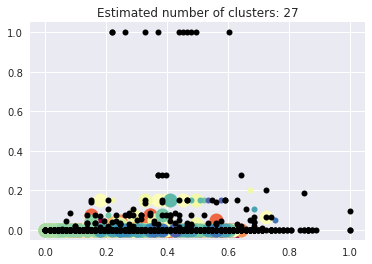

In [16]:
# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = df_pre_sampled[class_member_mask & core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = df_pre_sampled[class_member_mask & ~core_samples_mask]
    plt.plot(xy.iloc[:, 0], xy.iloc[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

28


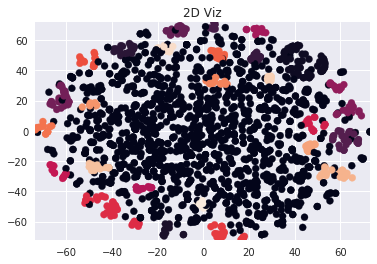

In [20]:
drawData(df_tsne_2d[index_sampled], pd.Series(db.labels_))

Le clustering spéctral, basé sur la théorie des graphes, peut révéler aussi quelques pistes. 

Le clustering d'affinity propagation n'a pas révélé d'information très intéressante.

/home/ubuntu/anaconda3/lib/python3.6/site-packages/scipy/sparse/csgraph/_laplacian.py:72: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if normed and (np.issubdtype(csgraph.dtype, int)


8


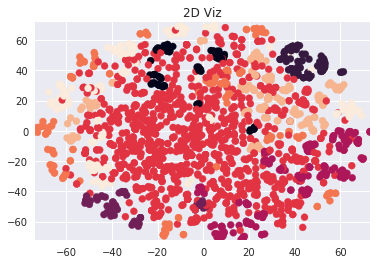

In [21]:
spc = SpectralClustering()
spc.fit(complete_preprocessed.loc[index_sampled, :])

drawData(df_tsne_2d[index_sampled], pd.Series(spc.labels_))


Le Mean Shift fait grandir les clusters un par un. Sans doute, cette méthode de clustering dépendant aussi de la densité des nuages de points, ne fonctionne pas très bien dans notre exemple de haute-dimension. 

1


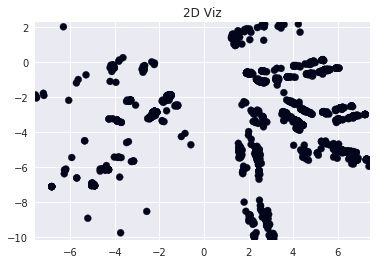

In [37]:
ms = MeanShift()
ms.fit(df_pre_sampled)

drawData(df_encoded, pd.Series(ms.labels_))